In [1]:
# https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
import kagglehub
brain_tumor_mri_dataset_path = kagglehub.dataset_download('masoudnickparvar/brain-tumor-mri-dataset')

print('Data source import complete.')

from google.colab import drive
drive.mount('/content/drive')


Data source import complete.
Mounted at /content/drive


# 1. Import needed libraries

In [2]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
#---------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
#---------------------------------------
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#---------------------------------------
import warnings
warnings.filterwarnings("ignore")

# 2. Preprocessing

## 2.1 Load data

In [3]:
#Glioma : U thần kinh đệm

def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df

In [4]:
def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])

    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return ts_df

In [5]:
tr_df = train_df('/kaggle/input/brain-tumor-mri-dataset/Training')

In [6]:
tr_df

Class Path      Class
0     /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
1     /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
2     /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
3     /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
4     /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
...                                                 ...        ...
5707  /kaggle/input/brain-tumor-mri-dataset/Training...     glioma
5708  /kaggle/input/brain-tumor-mri-dataset/Training...     glioma
5709  /kaggle/input/brain-tumor-mri-dataset/Training...     glioma
5710  /kaggle/input/brain-tumor-mri-dataset/Training...     glioma
5711  /kaggle/input/brain-tumor-mri-dataset/Training...     glioma

[5712 rows x 2 columns]

In [7]:
ts_df = test_df('/kaggle/input/brain-tumor-mri-dataset/Testing')

In [8]:
ts_df

Class Path      Class
0     /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary
1     /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary
2     /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary
3     /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary
4     /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary
...                                                 ...        ...
1306  /kaggle/input/brain-tumor-mri-dataset/Testing/...     glioma
1307  /kaggle/input/brain-tumor-mri-dataset/Testing/...     glioma
1308  /kaggle/input/brain-tumor-mri-dataset/Testing/...     glioma
1309  /kaggle/input/brain-tumor-mri-dataset/Testing/...     glioma
1310  /kaggle/input/brain-tumor-mri-dataset/Testing/...     glioma

[1311 rows x 2 columns]

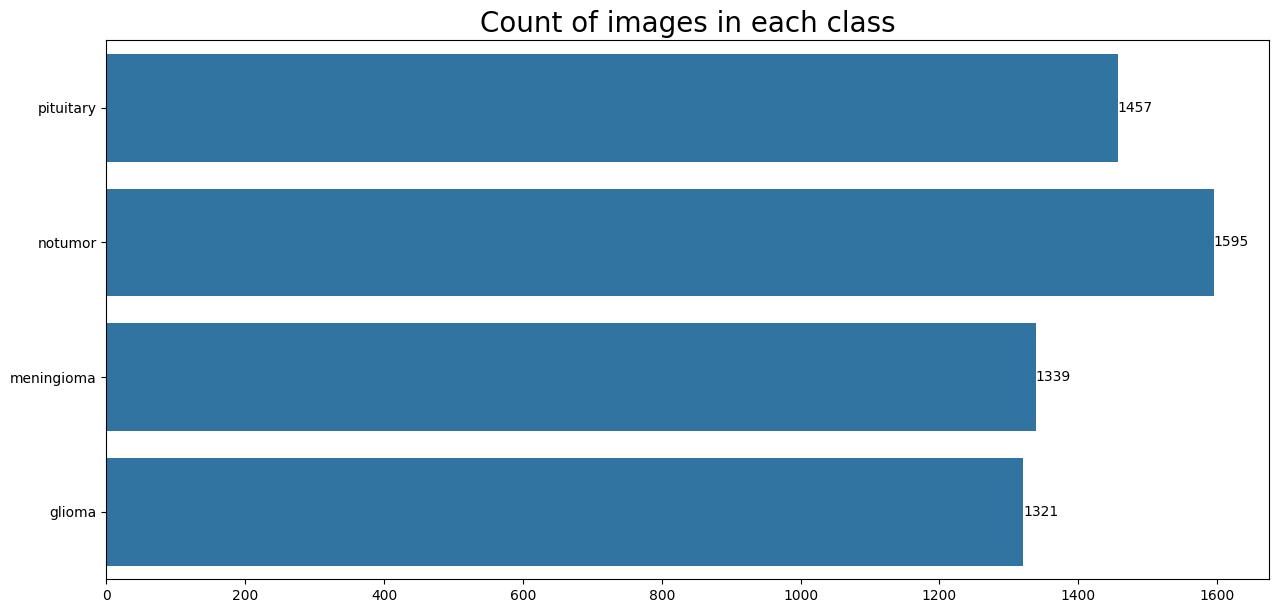

In [9]:
# Count of images in each class in train data
plt.figure(figsize=(15,7))
ax = sns.countplot(data=tr_df , y=tr_df['Class'])

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

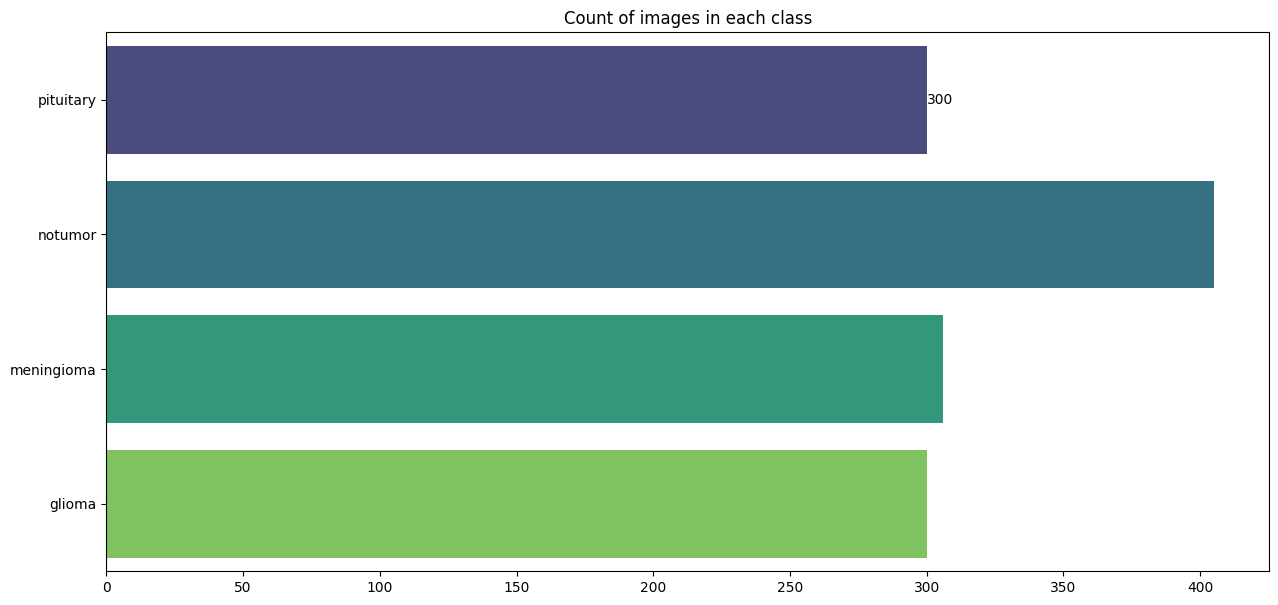

In [10]:
#Count each class in test data
plt.figure(figsize=(15, 7))
ax = sns.countplot(y=ts_df['Class'], palette='viridis')

ax.set(xlabel='', ylabel='', title='Count of images in each class')
ax.bar_label(ax.containers[0])

plt.show()

## 2.2 Split data into train, test, valid

In [11]:
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, random_state=20, stratify=ts_df['Class'])

In [12]:
valid_df

Class Path       Class
1297  /kaggle/input/brain-tumor-mri-dataset/Testing/...      glioma
723   /kaggle/input/brain-tumor-mri-dataset/Testing/...  meningioma
61    /kaggle/input/brain-tumor-mri-dataset/Testing/...   pituitary
778   /kaggle/input/brain-tumor-mri-dataset/Testing/...  meningioma
1120  /kaggle/input/brain-tumor-mri-dataset/Testing/...      glioma
...                                                 ...         ...
1070  /kaggle/input/brain-tumor-mri-dataset/Testing/...      glioma
554   /kaggle/input/brain-tumor-mri-dataset/Testing/...     notumor
1284  /kaggle/input/brain-tumor-mri-dataset/Testing/...      glioma
899   /kaggle/input/brain-tumor-mri-dataset/Testing/...  meningioma
626   /kaggle/input/brain-tumor-mri-dataset/Testing/...     notumor

[655 rows x 2 columns]

## 2.3 Data preprocessing

In [13]:
batch_size = 32
img_size = (299, 299)

_gen = ImageDataGenerator(rescale=1/255,
                          brightness_range=(0.8, 1.2))

ts_gen = ImageDataGenerator(rescale=1/255)


tr_gen = _gen.flow_from_dataframe(tr_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size)

valid_gen = _gen.flow_from_dataframe(valid_df, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col='Class Path',
                                  y_col='Class', batch_size=16,
                                  target_size=img_size, shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


## 2.4 Getting samples from data

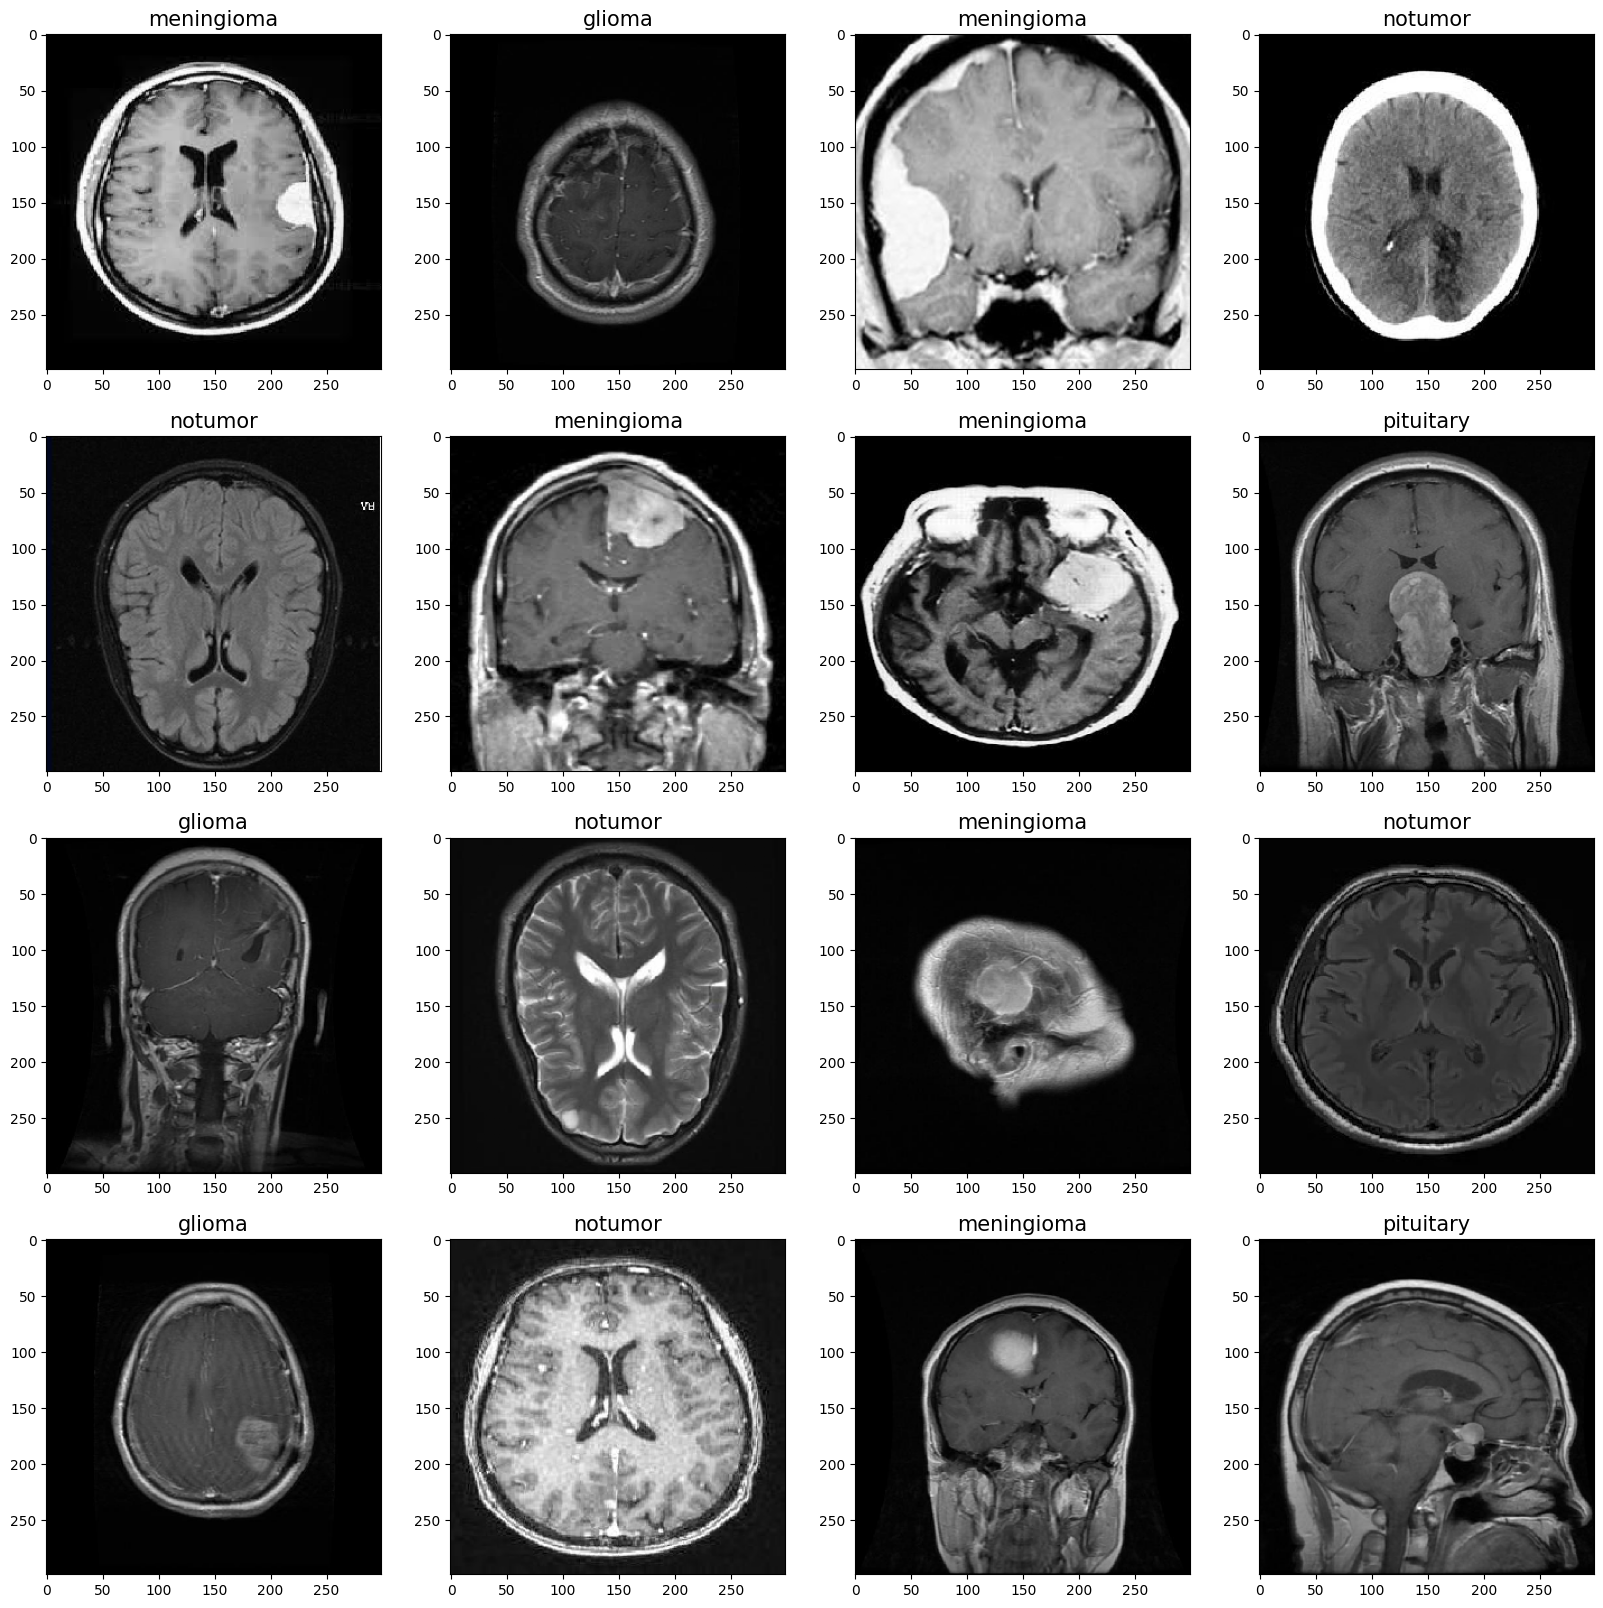

In [14]:
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(ts_gen)

plt.figure(figsize=(20, 20))

for i, (image, label) in enumerate(zip(images, labels)):
    plt.subplot(4,4, i + 1)
    plt.imshow(image)
    class_name = classes[np.argmax(label)]
    plt.title(class_name, color='k', fontsize=15)

plt.show()

# 3. Building Deep Learning Model

In [15]:
img_shape=(299,299,3)
base_model = tf.keras.applications.Xception(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max')

# for layer in base_model.layers:
#     layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate= 0.3),
    Dense(128, activation= 'relu'),
    Dropout(rate= 0.25),
    Dense(4, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])

model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,124,268 (80.58 MB)

 Trainable params: 21,069,740 (80.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

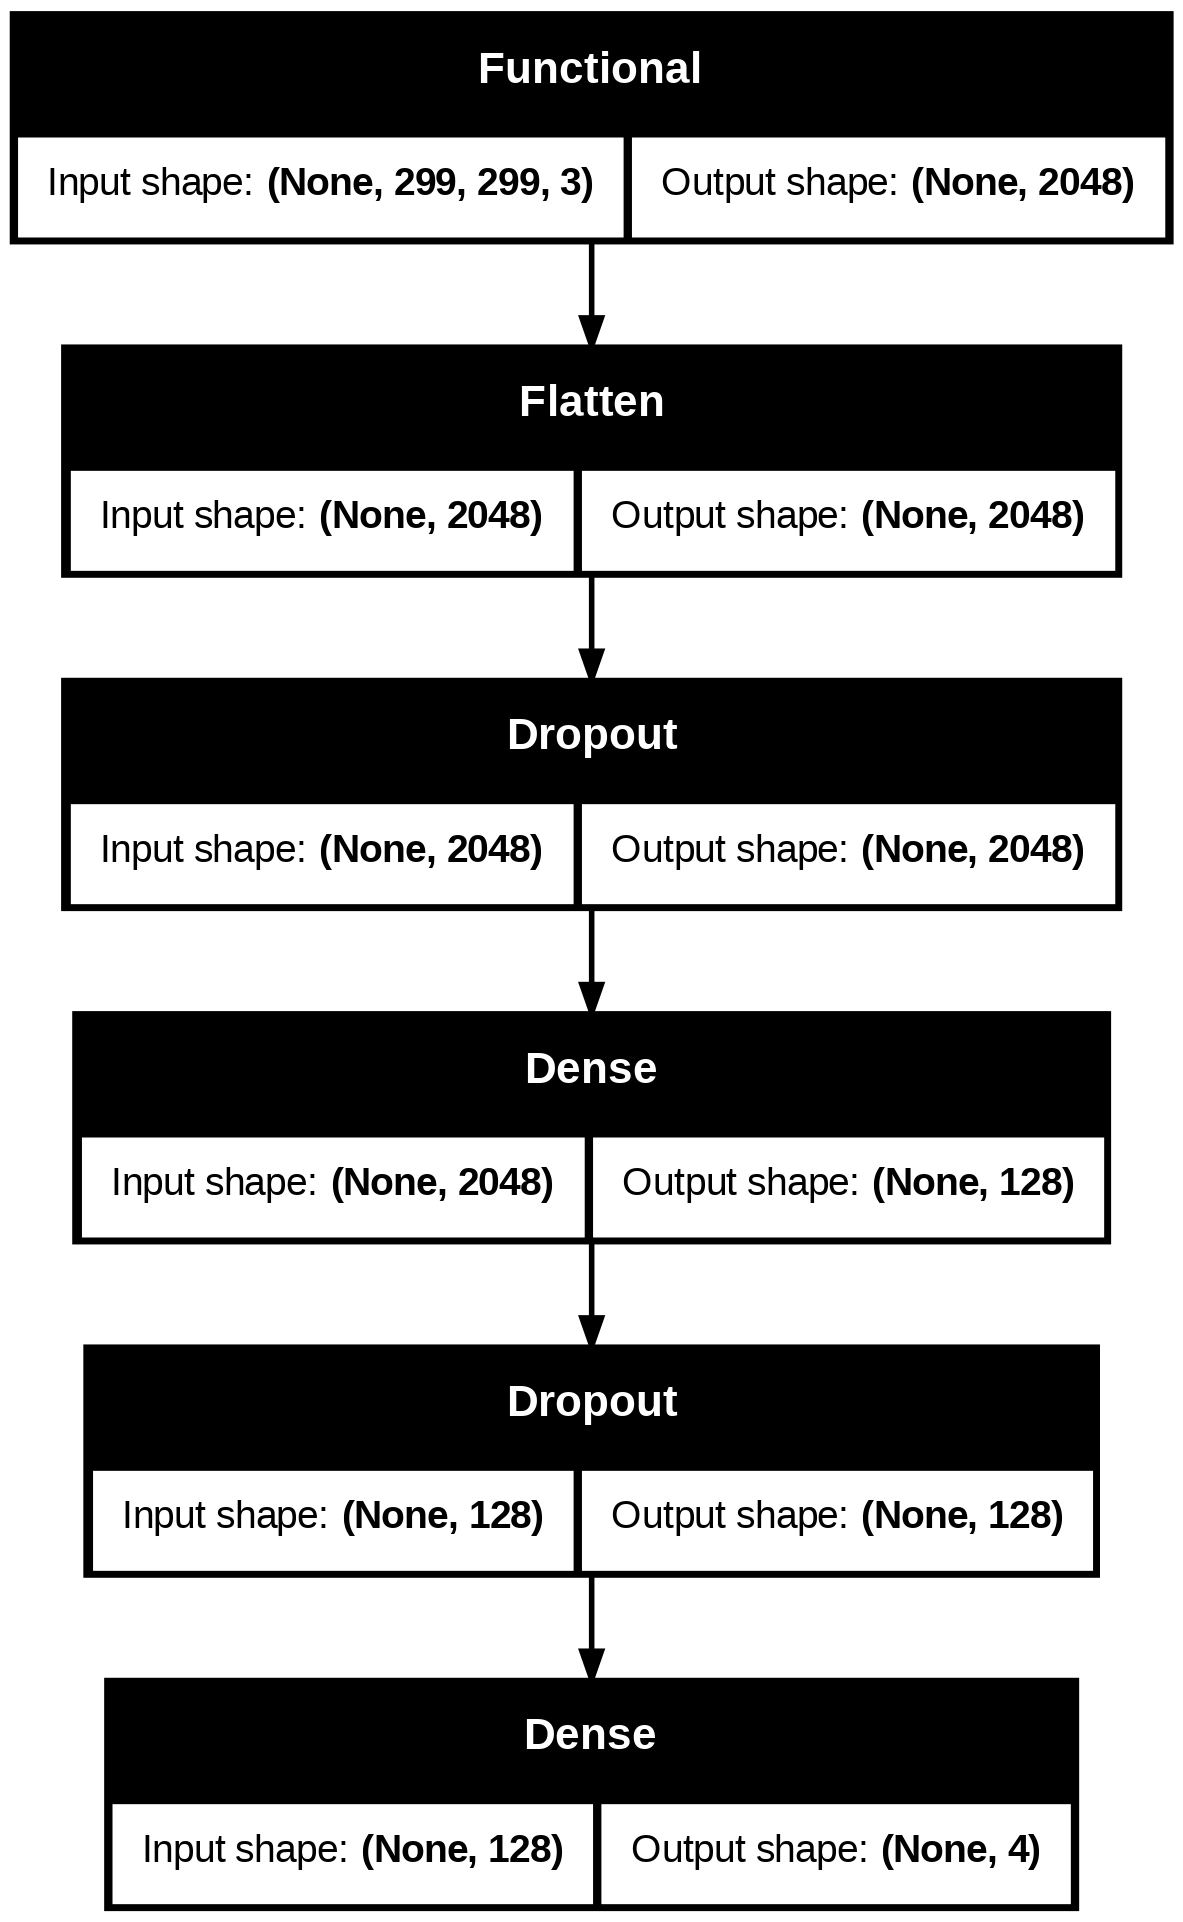

In [16]:
tf.keras.utils.plot_model(model, show_shapes=True)

# 4. Training

In [17]:
hist = model.fit(tr_gen,
                 epochs=10,
                 validation_data=valid_gen,
                 shuffle= False)

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 260s 1s/step - accuracy: 0.7526 - loss: 0.6969 - precision: 0.8351 - recall: 0.6444 - val_accuracy: 0.9008 - val_loss: 0.2709 - val_precision: 0.9109 - val_recall: 0.8901
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 160s 893ms/step - accuracy: 0.9810 - loss: 0.0572 - precision: 0.9823 - recall: 0.9795 - val_accuracy: 0.9832 - val_loss: 0.0470 - val_precision: 0.9831 - val_recall: 0.9786
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 161s 901ms/step - accuracy: 0.9914 - loss: 0.0272 - precision: 0.9917 - recall: 0.9913 - val_accuracy: 0.9832 - val_loss: 0.0441 - val_precision: 0.9847 - val_recall: 0.9802
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 162s 902ms/step - accuracy: 0.9924 - loss: 0.0253 - precision: 0.9937 - recall: 0.9924 - val_accuracy: 0.9893 - val_loss: 0.0260 - val_precision: 0.9893 - val_recall: 0.9893
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 166s 928ms/step - accuracy: 0.9963 - loss: 0.0141 - precision: 0.9964 - recall: 0.9955 - val_accuracy: 0.98

In [18]:
hist.history.keys()

dict_keys(['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall'])

## 4.1 Visualize model performance

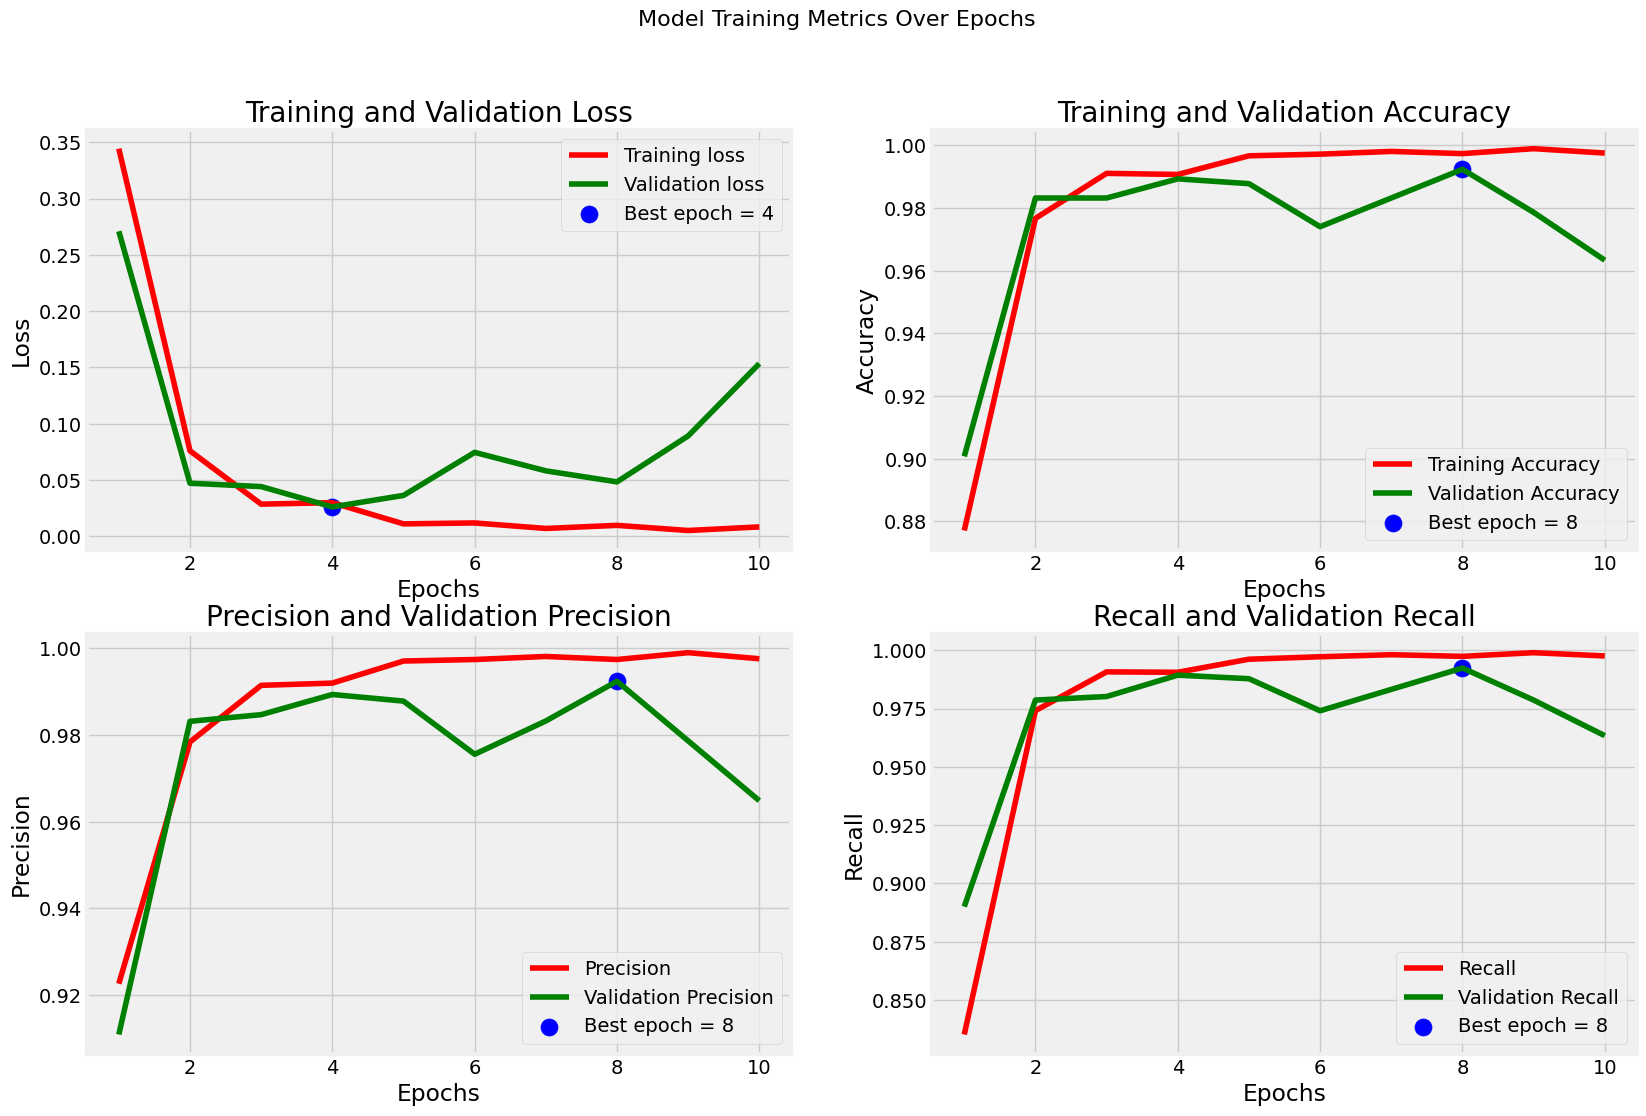

In [19]:
tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']
tr_per = hist.history['precision']
tr_recall = hist.history['recall']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
val_per = hist.history['val_precision']
val_recall = hist.history['val_recall']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'


plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')


plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

# 5. Testing and Evaluation

## 5.1 Evaluate

In [20]:
train_score = model.evaluate(tr_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(ts_gen, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")


179/179 ━━━━━━━━━━━━━━━━━━━━ 50s 276ms/step - accuracy: 0.9856 - loss: 0.0426 - precision: 0.9858 - recall: 0.9856
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 247ms/step - accuracy: 0.9537 - loss: 0.1867 - precision: 0.9566 - recall: 0.9537
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.9577 - loss: 0.2226 - precision: 0.9577 - recall: 0.9577
Train Loss: 0.0352
Train Accuracy: 98.83%
--------------------
Validation Loss: 0.1538
Validation Accuracy: 96.18%
--------------------
Test Loss: 0.1878
Test Accuracy: 96.34%


In [21]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step


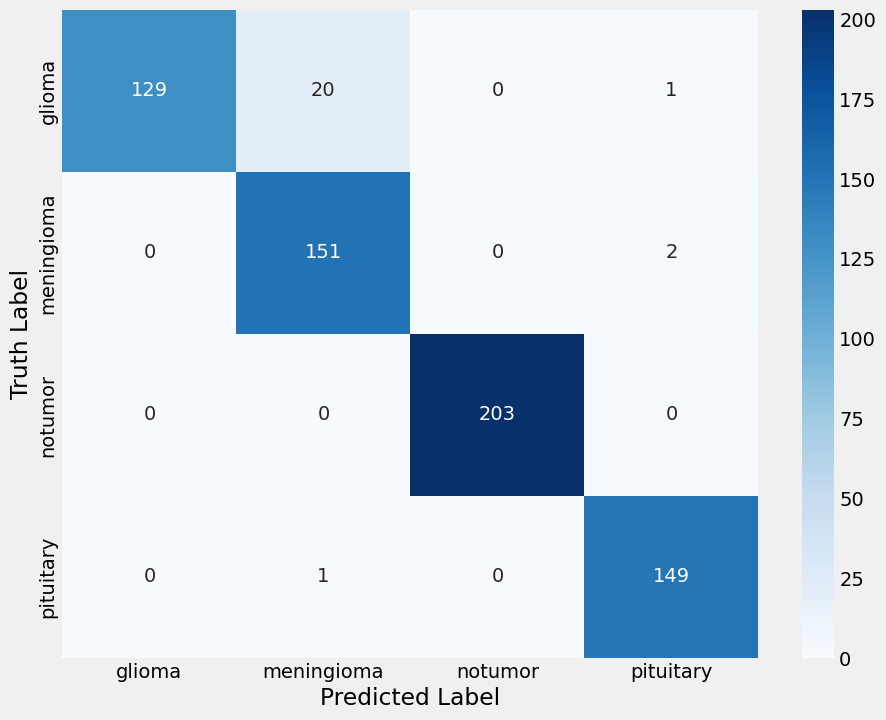

In [22]:
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

In [23]:
clr = classification_report(ts_gen.classes, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       1.00      0.86      0.92       150
           1       0.88      0.99      0.93       153
           2       1.00      1.00      1.00       203
           3       0.98      0.99      0.99       150

    accuracy                           0.96       656
   macro avg       0.96      0.96      0.96       656
weighted avg       0.97      0.96      0.96       656



## 5.2 Testing

In [24]:
def predict(img_path):
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image
    label = list(class_dict.keys())
    plt.figure(figsize=(12, 12))
    img = Image.open(img_path)
    resized_img = img.resize((299, 299))
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    img = img / 255
    predictions = model.predict(img)
    probs = list(predictions[0])
    labels = label
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


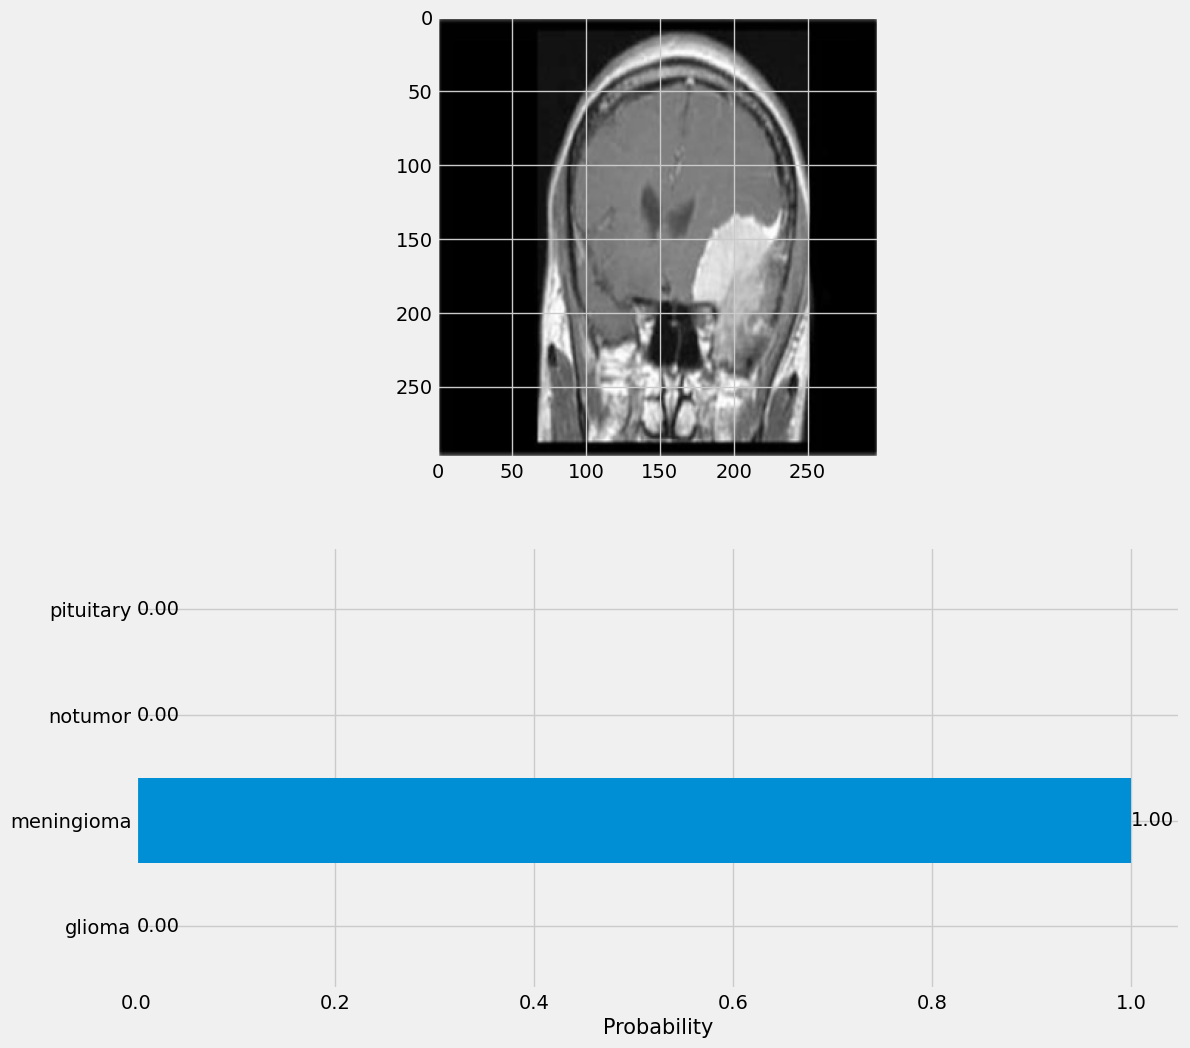

In [25]:
predict('/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/Te-meTr_0000.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


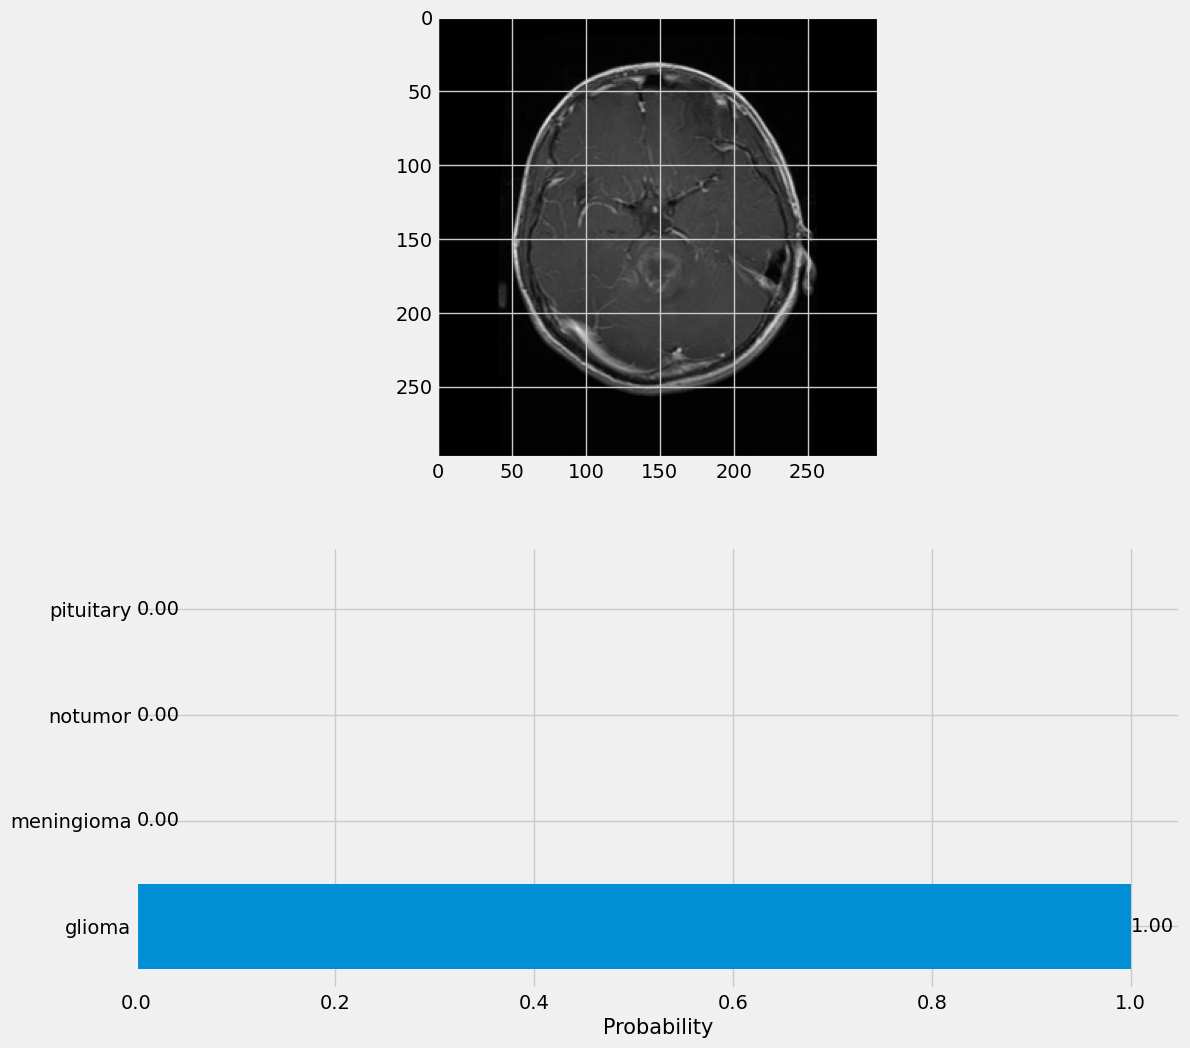

In [26]:
predict('/kaggle/input/brain-tumor-mri-dataset/Testing/glioma/Te-glTr_0007.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


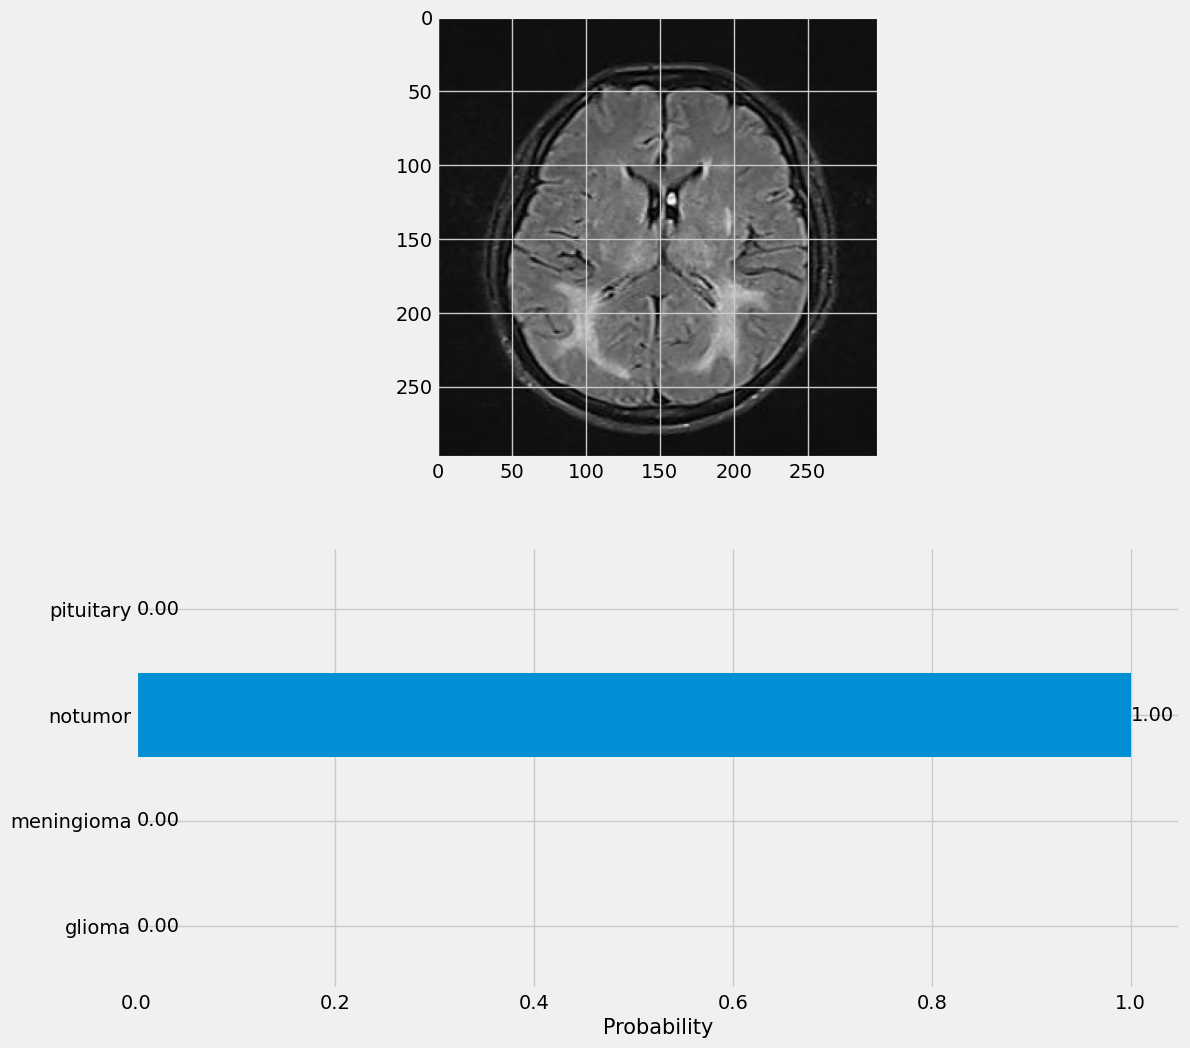

In [27]:
predict('/kaggle/input/brain-tumor-mri-dataset/Testing/notumor/Te-noTr_0001.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


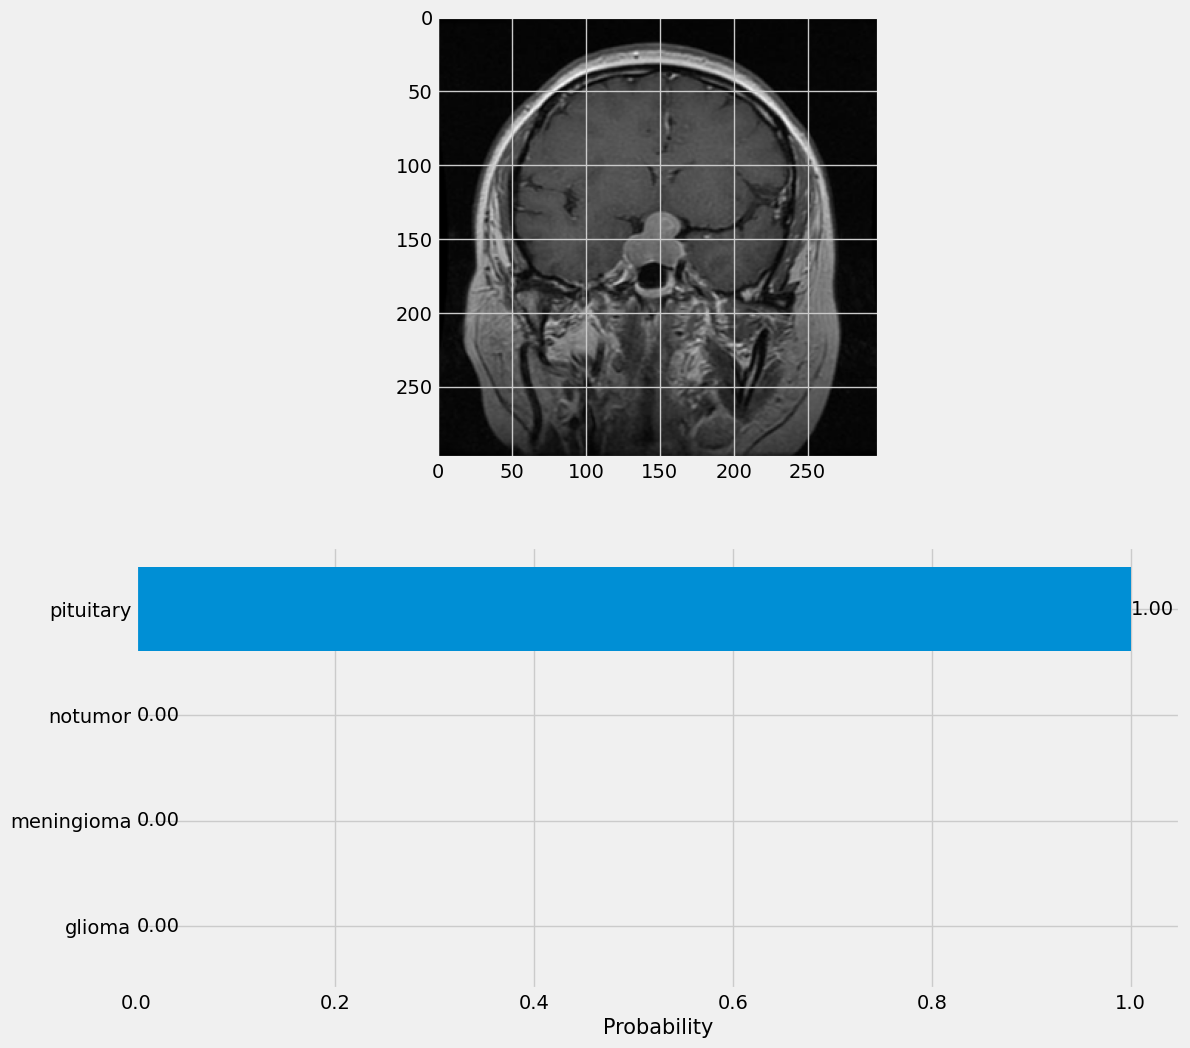

In [28]:
predict('/kaggle/input/brain-tumor-mri-dataset/Testing/pituitary/Te-piTr_0001.jpg')

Save Model



# Save Model

In [38]:
# 6. LƯU MODEL VÀO GOOGLE DRIVE

from google.colab import drive
import os

# Kết nối Google Drive với Colab
try:
    drive.mount('/content/drive')
    print("Google Drive mounted successfully!")
except Exception as e:
    print(f"Error mounting Google Drive: {e}")
    # Bạn có thể quyết định dừng ở đây nếu không kết nối được Drive
    # raise e

# Xác định đường dẫn và tên file model
# Đường dẫn người dùng yêu cầu: "My Drive/Colab Notebooks/DACS"
# Trong Colab, "My Drive" thường là /content/drive/MyDrive/
google_drive_base_path = '/content/drive/MyDrive/'
colab_notebooks_folder_name = 'ColabNotebooks' # Thư mục chuẩn của Colab
dacs_project_folder_name = 'DACS1' # Thư mục dự án của bạn

# Tạo đường dẫn đầy đủ tới thư mục DACS
# os.path.join giúp tạo đường dẫn đúng trên mọi hệ điều hành (mặc dù Colab là Linux)
target_directory_on_drive = os.path.join(google_drive_base_path,
                                         colab_notebooks_folder_name,
                                         dacs_project_folder_name)

# Tạo thư mục DACS trên Google Drive nếu nó chưa tồn tại
# exist_ok=True sẽ không báo lỗi nếu thư mục đã tồn tại
try:
    os.makedirs(target_directory_on_drive, exist_ok=True)
    print(f"Directory '{target_directory_on_drive}' is ready.")
except Exception as e:
    print(f"Error creating directory on Google Drive: {e}")
    # Có thể dừng nếu không tạo được thư mục
    # raise e

# Đặt tên cho file model (sử dụng định dạng .keras được khuyến nghị)
model_filename = 'xception_brain_tumor_classifier.keras'
full_model_save_path_on_drive = os.path.join(target_directory_on_drive, model_filename)

# Lưu model
# Biến 'model' chính là model bạn đã huấn luyện trong notebook
try:
    print(f"Attempting to save model to: {full_model_save_path_on_drive}")
    model.save(full_model_save_path_on_drive)
    print(f"Model đã được lưu thành công vào Google Drive tại: {full_model_save_path_on_drive}")
except Exception as e:
    print(f"Lỗi khi lưu model: {e}")

# (Tùy chọn) Liệt kê các file trong thư mục đích để xác nhận
try:
    print("\nCác file trong thư mục đích trên Google Drive:")
    for item in os.listdir(target_directory_on_drive):
        print(item)
except Exception as e:
    print(f"Không thể liệt kê các file trong thư mục đích: {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully!
Directory '/content/drive/MyDrive/ColabNotebooks/DACS1' is ready.
Attempting to save model to: /content/drive/MyDrive/ColabNotebooks/DACS1/xception_brain_tumor_classifier.keras
Model đã được lưu thành công vào Google Drive tại: /content/drive/MyDrive/ColabNotebooks/DACS1/xception_brain_tumor_classifier.keras

Các file trong thư mục đích trên Google Drive:
xception_brain_tumor_classifier.keras


An error occurred while saving the model: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=/content/drive/MyDrive/Colab Notebooks/DACS.


#